<a href="https://colab.research.google.com/github/stochasticats/plantpathologyfgvc7-keras-deeplearning/blob/master/Plant_Pathology_FGVC7_Identifying_foliar_disease_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Pathology 2020 - FGVC7
Identify the category of foliar diseases in apple trees

Kaggle competition - https://www.kaggle.com/c/plant-pathology-2020-fgvc7/submit

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.__version__)
import os
import shutil
import matplotlib.pyplot as plt

2.3.0


#Loading Data and Preprocessing
Here we load the data and take a look at what we're dealing with.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -uq "/content/drive/My Drive/plant-pathology-2020-fgvc7.zip"

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

target = train[['healthy', 'multiple_diseases', 'rust', 'scab']]
test_ids = test['image_id']

train_len = train.shape[0]
test_len = test.shape[0]

train.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [5]:
print("Shape of train data: " + str(train.shape))
print("Shape of test data: " + str(test.shape))

Shape of train data: (1821, 5)
Shape of test data: (1821, 1)


In [6]:
train_len = train.shape[0]
test_len = test.shape[0]
print(train_len)
print(test_len) 

1821
1821


Let's see the distribution of images in terms of the targets/labels.

In [7]:
print(train.describe())
print(test.describe())

           healthy  multiple_diseases         rust         scab
count  1821.000000        1821.000000  1821.000000  1821.000000
mean      0.283361           0.049973     0.341571     0.325096
std       0.450754           0.217948     0.474367     0.468539
min       0.000000           0.000000     0.000000     0.000000
25%       0.000000           0.000000     0.000000     0.000000
50%       0.000000           0.000000     0.000000     0.000000
75%       1.000000           0.000000     1.000000     1.000000
max       1.000000           1.000000     1.000000     1.000000
        image_id
count       1821
unique      1821
top     Test_952
freq           1


Ah, we see the multiple_diseases label has drastically less images than the rest of the labels. Once we load the images in raw data form, we'll use scikitlearn to randomly over sample so we can fix this class imbalance.

Now let's load the image data.

In [8]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tqdm.notebook import tqdm

path = '/content/images/'
size = 224

train_images = np.ndarray(shape=(train_len, size, size, 3))
for i in tqdm(range(train_len)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images[i] = np.uint8(img_to_array(img))

test_images = np.ndarray(shape=(test_len, size, size, 3))
for i in tqdm(range(test_len)):
  img = load_img(path + f'Test_{i}.jpg', target_size=(size, size))
  test_images[i] = np.uint8(img_to_array(img))

train_images.shape, test_images.shape

((1821, 224, 224, 3), (1821, 224, 224, 3))

In [9]:
print(train_images.shape)
print(test_images.shape)

(1821, 224, 224, 3)
(1821, 224, 224, 3)


Here we see the images are in raw data form, with three matrices for RGB format. We'll rescale later on as well.

Let's take a look at what the images look like.

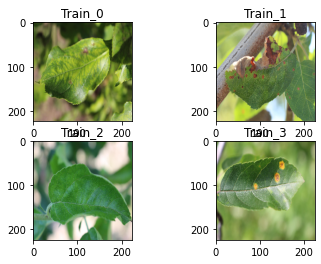

<Figure size 432x288 with 0 Axes>

In [10]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(train['image_id'][i])
	plt.imshow(np.uint8(train_images[i]))
plt.show()
plt.savefig('train_images.png')

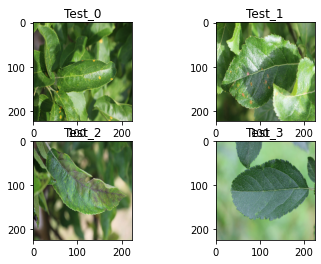

<Figure size 432x288 with 0 Axes>

In [11]:
for i in range(4):
	plt.subplot(220 + 1 + i)
	plt.title(test['image_id'][i])
	plt.imshow(np.uint8(test_images[i]))
plt.show()
plt.savefig('test_images.png')

Let's split out data into train and test sets for the model.

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_images, target.to_numpy(), test_size=0.1, random_state=289) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1638, 224, 224, 3), (183, 224, 224, 3), (1638, 4), (183, 4))

Now use RandomOverSampler to fix our class imbalance in the multiple diseases class.

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=289)

x_train, y_train = ros.fit_resample(x_train.reshape((-1, size * size * 3)), y_train)
x_train = x_train.reshape((-1, size, size, 3))
x_train.shape, y_train.shape

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((2240, 224, 224, 3), (2240, 4))

In [14]:
import gc

del train_images
gc.collect()

16140

Now we prepare the data for going into a Keras deep learning model. Here I use the ImageDataGenerator to also give us more images by using the parameters to rotate, horizontally flip, and vertically flip. Also the image is rescaled by 1/255 to normalize the raw data so that the activation functions work properly.

In [15]:
from keras_preprocessing.image import ImageDataGenerator

batch_size = 8

train_datagen = ImageDataGenerator(samplewise_center = True,
                                   samplewise_std_normalization = True,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range=20)

train_generator = train_datagen.flow(
    x = x_train, 
    y = y_train,
    batch_size = batch_size)

validation_datagen = ImageDataGenerator(samplewise_center = True,
                                        samplewise_std_normalization = True)

validation_generator = validation_datagen.flow(
    x = x_test, 
    y = y_test,
    batch_size = batch_size)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


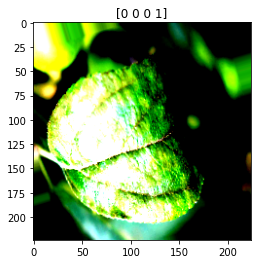

In [16]:
idx = np.random.randint(8)
x, y = train_generator.__getitem__(idx)
plt.title(y[idx])
plt.imshow(x[idx])
plt.savefig('processed_img.png')

# Model
Let's create the model. Here I build a custom model consisting of convolution layers of ascending filter size, a flatten, and 2 dense layers with the last activation function being the softmax so we can predict between four classes.

In [22]:
def create_model():
    #pre_trained = tf.keras.applications.MobileNet(input_shape=(size, size, 3), weights='imagenet', include_top=False, dropout = 0.3)
    pre_trained = tf.keras.applications.ResNet50(include_top = False, weights='imagenet', input_shape=(size, size, 3))
    
    #pretrained_model = tf.keras.applications.mobilenet.MobileNet(input_shape=(SIZE,SIZE,3), include_top=False)
    model = tf.keras.Sequential([
      pre_trained,
      #tf.keras.layers.Conv2D(32, (3,3), input_shape=(size, size, 3)),
      #tf.keras.layers.BatchNormalization(),
      #tf.keras.layers.Activation('relu'),
      #tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      #tf.keras.layers.Conv2D(64, (3,3)),
      #tf.keras.layers.BatchNormalization(),
      #tf.keras.layers.Activation('relu'),
      #tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      #tf.keras.layers.Conv2D(128, (3,3)),
      #tf.keras.layers.BatchNormalization(),
      #tf.keras.layers.Activation('relu'),
      #tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      #tf.keras.layers.Flatten(),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(4, activation='softmax')
      ])
    model.compile(
        loss = 'kullback_leibler_divergence', 
        optimizer = 'adam', 
        metrics = ['accuracy'])
    return model

model = create_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [23]:
epochs = 50
steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = x_test.shape[0] // batch_size
print(steps_per_epoch)

280


Let's set up some callbacks. 
Callbacks:

**EarlyStopping** - stop early if the validation loss has stopped improving

**ModelCheckpoint** - save the model every epoch and save the best weights

**ReduceLROnPlateau** - reduce learning rate when validation loss has stopped improving

**LearningRateScheduler** - set learning rate to ramp up during early epochs



Learning rate per epoch:


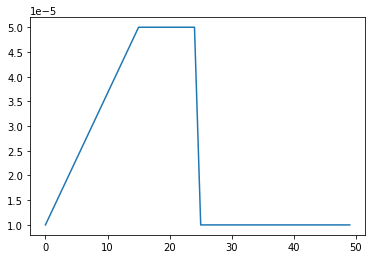

In [24]:
es = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('model.hdf5', save_best_only=True, verbose=0)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1)

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 15
sustain_epochs = 10
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return min_lr
    
lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(epochs)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

Now that we've built the model and set up our model parameters, let's train it and see what happens!

In [25]:
history = model.fit(
    x = train_generator,  
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    verbose=1,
    callbacks=[es, lr, mc, rlr])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
280/280 [==============================] - 25s 88ms/step - loss: 1.0483 - accuracy: 0.5674 - val_loss: 1.9632 - val_accuracy: 0.4091

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2666666666666668e-05.
Epoch 2/50
280/280 [==============================] - 24s 86ms/step - loss: 0.5566 - accuracy: 0.8062 - val_loss: 0.8063 - val_accuracy: 0.6761

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5333333333333334e-05.
Epoch 3/50
280/280 [==============================] - 24s 86ms/step - loss: 0.3591 - accuracy: 0.8768 - val_loss: 0.2772 - val_accuracy: 0.9091

Epoch 00004: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 4/50
280/280 [==============================] - 24s 86ms/step - loss: 0.2647 - accuracy: 0.9062 - val_loss: 0.2400 - val_accuracy: 0.9261

Epoch 00005: LearningRateScheduler reducing learning rate to 2.066666666666667e-05.
Epoch 5/50
2

# Results
We plot the train and validation accuracy and loss to see how the model did over the epochs.

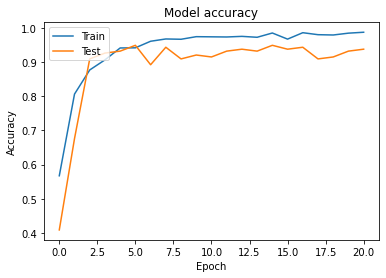

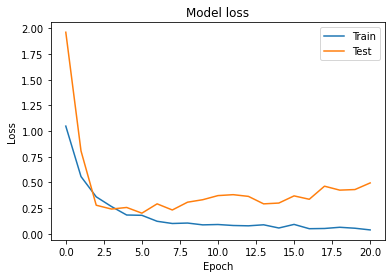

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Let's look at the last accuracy rate in terms of error.

In [27]:
train_err = (1-history.history['accuracy'][-1])*100
validation_err = (1-history.history['val_accuracy'][-1])*100
print("Train set error " + str(train_err))
print("Validation set error " + str(validation_err))

Train set error 1.294642686843872
Validation set error 6.25


#Prediction
Here we feed the test image set into the model.predict function and see how our model does.

In [28]:
test_datagen = ImageDataGenerator(samplewise_center = True,
                                 samplewise_std_normalization = True)

test_generator = test_datagen.flow(
    x = test_images,
    shuffle = False)

In [29]:
probabilities = model.predict(test_generator, steps = len(test_generator))
print(probabilities)
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

[[1.3099525e-04 1.2081534e-02 9.8684084e-01 9.4667700e-04]
 [2.4708709e-06 2.9836301e-04 9.9969327e-01 5.9711451e-06]
 [2.7618344e-05 4.9374555e-04 1.5000053e-04 9.9932873e-01]
 ...
 [1.0175887e-02 8.1611324e-05 9.8970526e-01 3.7332757e-05]
 [9.9897695e-01 1.6433409e-04 7.0383790e-04 1.5485888e-04]
 [2.0634415e-02 5.8510765e-02 8.2728371e-02 8.3812642e-01]]
26.033756136894226
9.207630902528763
39.15603160858154
25.602582097053528


In [30]:
valid_probabilities = model.predict(validation_generator, steps = len(validation_generator))
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

26.033756136894226
9.207630902528763
39.15603160858154
25.602582097053528


In [31]:
train_probabilities = model.predict(train_generator, steps = len(train_generator))
print(probabilities[:,0].mean()*100)
print(probabilities[:,1].mean()*100)
print(probabilities[:,2].mean()*100)
print(probabilities[:,3].mean()*100)

26.033756136894226
9.207630902528763
39.15603160858154
25.602582097053528


In [32]:
test = pd.read_csv('test.csv')
res = pd.DataFrame()
res['image_id'] = test['image_id']
res['healthy'] = probabilities[:, 0]
res['multiple_diseases'] = probabilities[:, 1]
res['rust'] = probabilities[:, 2]
res['scab'] = probabilities[:, 3]

In [33]:
res.to_csv('submission.csv', index=False)

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, valid_probabilities)

0.5457187607104108